In [1]:
# Install library for reading JPK File
# %pip uninstall pyafmreader --yes
# %pip install git+https://github.com/jlopezalo/pyafmreader.git

In [2]:
# Install library for AFM data Rheology Analysis
%pip uninstall pyafmrheo --yes
%pip install git+https://github.com/jlopezalo/pyafmrheo.git

Found existing installation: pyafmrheo 0.0.1
Uninstalling pyafmrheo-0.0.1:
  Successfully uninstalled pyafmrheo-0.0.1
Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/jlopezalo/pyafmrheo.git to /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-req-build-xp6d5m6e
  Running command git clone -q https://github.com/jlopezalo/pyafmrheo.git /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-req-build-xp6d5m6e
  Created wheel for pyafmrheo: filename=pyafmrheo-0.0.1-py3-none-any.whl size=32824 sha256=533587e5e084ff8b8d5bc8dbeb367f86b9cec4f3fe1a999cee206282ea5f6c7a
  Stored in directory: /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-ephem-wheel-cache-0ofdhdcz/wheels/fb/66/18/3e93b45c845b0d7b83ded1e127a1c127820d070ce5b71dece4
Successfully built pyafmrheo
Note: you may need to restart the kernel to use updated packages.


In [41]:
# Import libraries we will need
import numpy as np
import matplotlib.pyplot as plt

# Get file reader from library
from pyafmreader import loadfile

# Get data analysis tools
from pyafmrheo.utils.force_curves import *
from pyafmrheo.models.hertz import HertzModel
from pyafmrheo.models.ting import TingModel

In [42]:
# Define global variables
# file_path = '/Users/javierlopez/Documents/Marseille/05-11-2021/E/map-data-2021.11.05-15.41.45.699.jpk-force-map'
file_path = '/Users/javierlopez/Documents/testingPyFM/map-data-2021.12.06-19.40.19.296.jpk-force-map'
# file_path = '/Users/javierlopez/Documents/pyafmreader/tests/testfiles/20200903_Egel2.0_00023.spm'
# file_path = '/Users/javierlopez/Documents/pyafmreader/tests/testfiles/20200904_Egel4-Z1.0_00025.spm'
# file_path = '/Users/javierlopez/Documents/pyafmreader/tests/testfiles/08171528.0_00001.pfc'
# Shapes available: paraboloid, pyramid
indenter_shape = "paraboloid"
# indenter_shape = "pyramid"
tip_parameter = 30 * 1e-9 # meters
# tip_parameter = 35 # degrees
# Poisson ratio
poisson_ratio = 0.5
# If None it will use the deflection sensitivity from the file
deflection_sensitivity = None # m/V
# If None it will use the spring constant from the file
spring_constant = None # N/m
# General plotting params
plt.rcParams["figure.figsize"] = (10,5)
vdrag = 0

In [43]:
file = loadfile(file_path)

In [44]:
filemetadata = file.filemetadata
# print(filemetadata)

In [45]:
closed_loop = filemetadata['z_closed_loop']
file_deflection_sensitivity = filemetadata['defl_sens_nmbyV'] #nm/V
file_spring_constant = filemetadata['spring_const_Nbym'] #N/m
height_channel = filemetadata['height_channel_key']

if not deflection_sensitivity: deflection_sensitivity = file_deflection_sensitivity / 1e9 #m/V
if not spring_constant: spring_constant = file_spring_constant
    
print(file_spring_constant)
print(deflection_sensitivity)

0.135
7.469391092311744e-09


In [46]:
curve_idx = 0
# curve_idx = 4
force_curve = file.getcurve(curve_idx)
extend_segments = force_curve.extend_segments
pause_segments = force_curve.pause_segments
modulation_segments = force_curve.modulation_segments
retract_segments = force_curve.retract_segments
force_curve_segments = force_curve.get_segments()

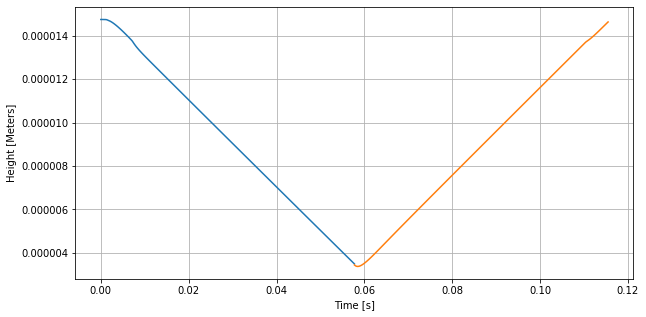

In [47]:
t0 = 0
for seg_id, segment in force_curve_segments:
    height = segment.segment_formated_data[height_channel]
    if seg_id == '1':
         height = height[::-1]
    time = segment.segment_formated_data["time"] + t0
    plt.plot(time, height)
    t0 = time[-1]

plt.xlabel("Time [s]")
plt.ylabel("Height [Meters]")
plt.grid()
plt.show()

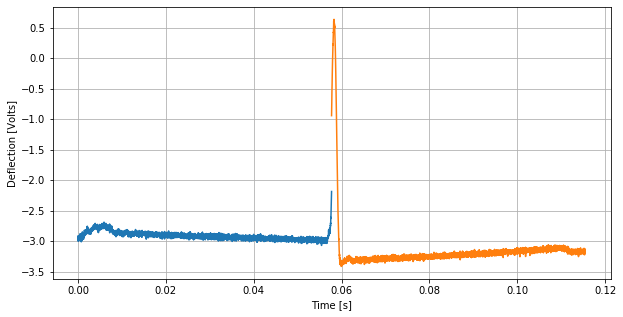

In [48]:
t0 = 0
for seg_id, segment in force_curve_segments:
    deflection = segment.segment_formated_data["vDeflection"]
    time = segment.segment_formated_data["time"] + t0
    plt.plot(time, deflection)
    t0 = time[-1]

plt.xlabel("Time [s]")
plt.ylabel("Deflection [Volts]")
plt.grid()
plt.show()

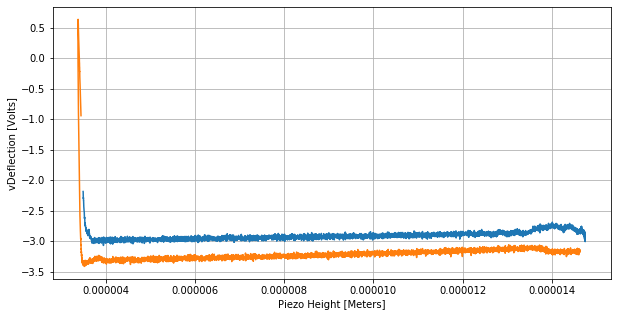

In [49]:
for seg_id, segment in force_curve_segments:
    height = segment.segment_formated_data[height_channel]
    deflection = segment.segment_formated_data["vDeflection"]
    plt.plot(height, deflection)

plt.xlabel("Piezo Height [Meters]")
plt.ylabel("vDeflection [Volts]")
plt.grid()
plt.show()

In [50]:
force_curve.preprocess_force_curve(deflection_sensitivity, height_channel)

# Get approach, first extend segment
first_exted_seg_id, first_ext_seg = extend_segments[0]

# Get retract, last retract segment
last_ret_seg_id, last_ret_seg = retract_segments[-1]

In [51]:
# Shift height
force_curve.shift_height()

In [52]:
t_offset = np.abs(first_ext_seg.zheight[-1] - last_ret_seg.zheight[0]) / 150e-6
dt = np.abs(first_ext_seg.time[1] - first_ext_seg.time[0])
print(t_offset > 2 * dt)
if t_offset > 2 * dt:
     last_ret_seg.time = last_ret_seg.time + t_offset

True


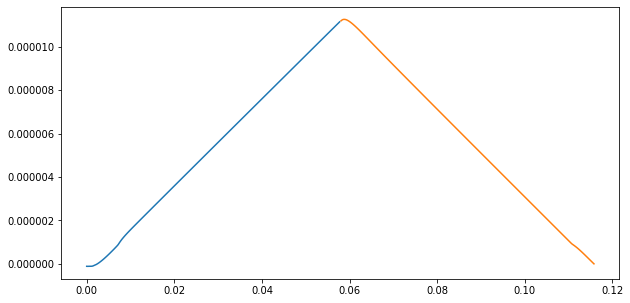

In [53]:
plt.plot(first_ext_seg.time, first_ext_seg.zheight)
plt.plot(last_ret_seg.time + first_ext_seg.time[-1], last_ret_seg.zheight)

In [54]:
app_height = first_ext_seg.zheight
app_deflection = first_ext_seg.vdeflection
ret_height = last_ret_seg.zheight
ret_deflection = last_ret_seg.vdeflection

In [55]:
first_ext_seg.velocity
first_ext_seg.segment_metadata

{'time_stamp': '2021-12-06 19\\:40\\:19.172 +0100',
 'num_points': 11548,
 'duration': 0.05774,
 'channels': ['height', 'vDeflection', 'measuredHeight'],
 'baseline_measured': True,
 'baseline': -2.9884720623757097,
 'approach_id': '2021.12.06-18.41.02-00078',
 'style': 'extend',
 'setpoint': 0.7933613132167481,
 'z_start': 14999.999999999998,
 'z_end': 0.0,
 'ramp_size': -14999.999999999998,
 'ramp_speed': -259785.2441981295}

In [56]:
np.abs(first_ext_seg.zheight.min() - first_ext_seg.zheight.max())

1.1265179354771167e-05

In [57]:
v0t = np.abs(first_ext_seg.zheight.min() - first_ext_seg.zheight.max())/first_ext_seg.segment_metadata['duration']
v0t *= 1e6
v0t

195.101824640997

In [58]:
v0r = np.abs(last_ret_seg.zheight.min() - last_ret_seg.zheight.max())/first_ext_seg.segment_metadata['duration']
v0r *= 1e6
v0r

195.03759951827195

In [59]:
# Find initial PoC, you may get some warnings.
poc = get_poc_RoV_method(app_height, app_deflection, win_size=50)
print(*poc)

1.093835277859725e-05 8.400562649599004e-11


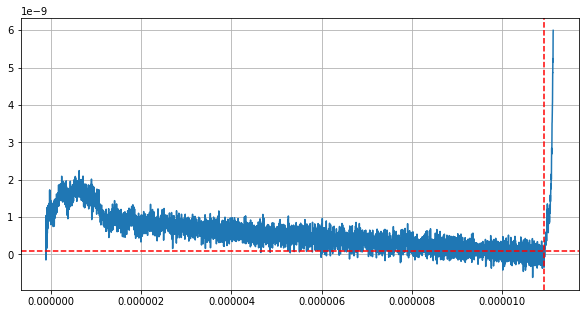

In [60]:
plt.plot(app_height, app_deflection)
plt.axvline(x=poc[0], color='r', linestyle='--')
plt.axhline(y=poc[1], color='r', linestyle='--')
plt.grid()
plt.show()

In [61]:
#plt.plot(app_height, app_deflection)
#mask = app_height<poc[0]
#plt.plot(app_height[mask], app_deflection[mask])
#z = np.poly1d(np.polyfit(app_height[mask], app_deflection[mask], 1))
#plt.plot(app_height[mask], z(app_height[mask]))
#plt.show()
#plt.plot(app_height, app_deflection-z(app_height))
#plt.plot(ret_height, ret_deflection-z(ret_height))
#first_ext_seg.vdeflection = app_deflection-z(app_height)
#last_ret_seg.vdeflection = ret_deflection-z(ret_height)


        # Fit parameters
        Indenter shape: paraboloid

        Tip paraneter: 3.0000000000000004e-08

        BEC Model: None

        Number of free parameters: 3

        delta0: 6.21905413149089e-08

        E0: 30957.945347277837

        f0: 6.359472688440074e-11

        slope: None

        # Fit metrics
        MAE: 4.584305438464996e-27

        MSE: 3.708021335501817e-21

        RMSE: 6.089352457775635e-11

        Rsq: 0.1793934758490231

        Chisq: -4.254765367761143e-07

        RedChisq: -1.4182551225870477e-07

        
30957.945347277837


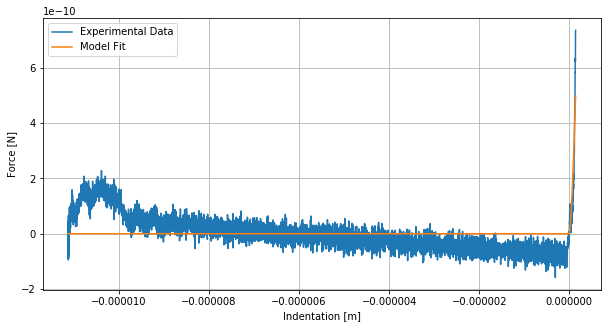

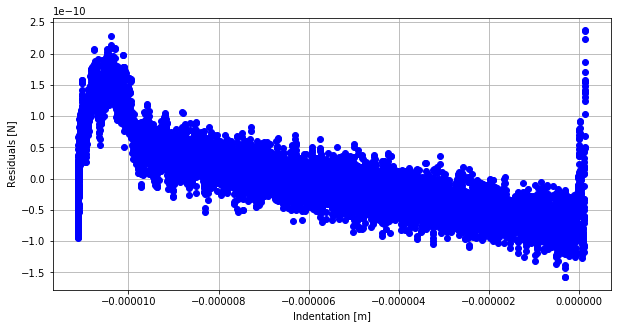

In [62]:
# Hertz fit
first_ext_seg.get_force_vs_indentation(poc, spring_constant)
app_indentation, app_force = first_ext_seg.indentation, first_ext_seg.force

# plt.plot(app_height - poc[0], app_deflection*spring_constant)
# plt.show()

# app_indentation = app_height - poc[0]
# app_force = app_deflection*spring_constant

hertzmodel = HertzModel(indenter_shape, tip_parameter)
hertzmodel.fit(app_indentation, app_force)

hertzmodel.fit_report()

hertz_E0 = hertzmodel.E0
hertz_d0 = hertzmodel.delta0
hertz_f0 = hertzmodel.f0

print(hertz_E0)

# Plot Hertz Fit results
plt.plot(app_indentation-hertz_d0, app_force-hertz_f0, label="Experimental Data")
plt.plot(app_indentation-hertz_d0, hertzmodel.eval(app_indentation)-hertz_f0, label="Model Fit")
plt.xlabel('Indentation [m]')
plt.ylabel('Force [N]')
plt.legend()
plt.grid()
plt.show()

# Plot residuals
plt.plot(app_indentation-hertz_d0, hertzmodel.get_residuals(app_indentation, app_force), "bo")
plt.xlabel('Indentation [m]')
plt.ylabel('Residuals [N]')
plt.grid()
plt.show()

In [63]:
# Get force vs indentation for all segments
poc[0] += hertz_d0

# Get indentation and force
first_ext_seg.get_force_vs_indentation(poc, spring_constant)
app_indentation, app_force, app_time = first_ext_seg.indentation, first_ext_seg.force, first_ext_seg.time
last_ret_seg.get_force_vs_indentation(poc, spring_constant)
ret_indentation, ret_force, ret_time = last_ret_seg.indentation, last_ret_seg.force, last_ret_seg.time

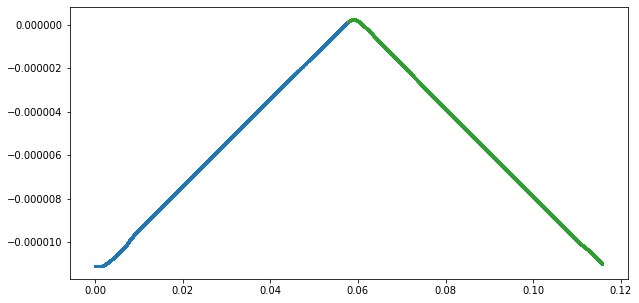

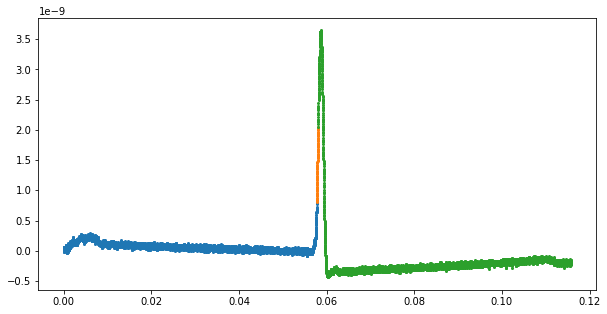

In [281]:
indentation = np.r_[app_indentation, ret_indentation]
yf_app_ind = app_indentation[-1]
y0_ret_ind = ret_indentation[0]
idx_tc = (np.abs(app_indentation - 0)).argmin()
yf_app_f = app_force[-1]
y0_ret_f = ret_force[0]
t0 = app_time[-1]
time = np.r_[app_time, ret_time + t0]
xf_app = app_time[-1]
x0_ret = (ret_time + t0)[0]
dt = time[1] - time[0]
nbrp_int = int(np.round((x0_ret-xf_app)/dt))
points = np.linspace(xf_app, x0_ret, num=nbrp_int)
int_points_f = np.interp(points, [xf_app, x0_ret], [yf_app_f, y0_ret_f])
int_points_ind = np.interp(points, [xf_app, x0_ret], [yf_app_ind, y0_ret_ind])
int_points_t = points
idx_start = nbrp_int//2
plt.plot(app_time, app_indentation, 'o', markersize=2)
plt.plot(points, int_points_ind, 'o', markersize=2)
plt.plot(ret_time + t0, ret_indentation, 'o', markersize=2)
plt.show()
plt.plot(app_time, app_force, 'o', markersize=2)
plt.plot(points, int_points_f, 'o', markersize=2)
plt.plot(ret_time + t0, ret_force, 'o', markersize=2)
plt.show()
indentation = np.r_[app_indentation, int_points_ind, ret_indentation]
fit_mask = indentation > (-1 * 1e-6)
time = np.r_[app_time, int_points_t, ret_time + t0]
force = np.r_[app_force, int_points_f, ret_force]
tc = time[idx_tc]
ind_fit = indentation[fit_mask]
force_fit = force[fit_mask]
force_fit = force_fit - force_fit[0]
time_fit = time[fit_mask]
tc_fit = tc-time_fit[0]
time_fit = time_fit - time_fit[0]
tm = time_fit[np.argmax(force_fit)]
idx_tm = np.argmax(force_fit)

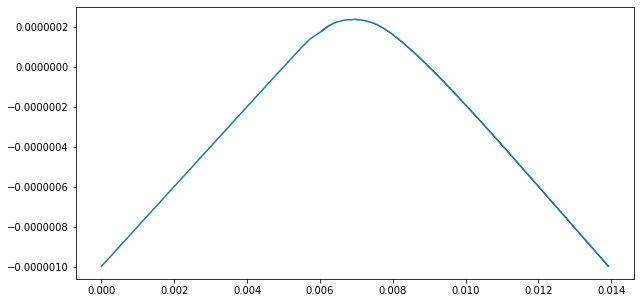

In [282]:
plt.plot(time_fit, ind_fit)

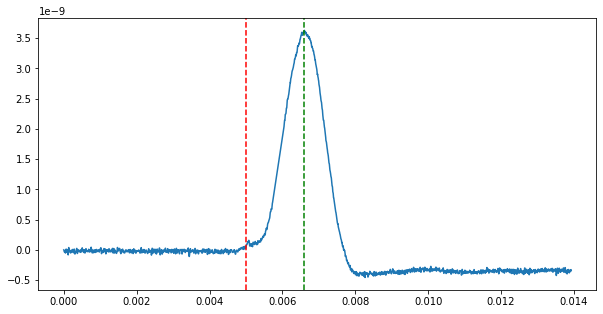

In [283]:
plt.plot(time_fit, force_fit)
plt.axvline(x=tc_fit, color='r', linestyle='--')
plt.axvline(x=tm, color='g', linestyle='--')
plt.show()

In [284]:
help(TingModel)

Help on class TingModel in module pyafmrheo.models.ting:

class TingModel(builtins.object)
 |  TingModel(ind_geom, tip_param, modelFt) -> None
 |  
 |  Methods defined here:
 |  
 |  SolveAnalytical(self, ttc, trc, t1, model_probe, geom_coeff, v0t, v0r, v0, E0, betaE, t0, F0, vdrag)
 |  
 |  SolveNumerical(self, delta, time_, geom_coeff, geom_exp, v0t, v0r, E0, betaE, F0, vdrag, smooth_w, idx_tm, idxCt, idxCr)
 |  
 |  __init__(self, ind_geom, tip_param, modelFt) -> None
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  eval(self, time, F, delta, t0, idx_tm=None, smooth_w=None, v0t=None, v0r=None)
 |  
 |  fit(self, time, F, delta, t0, idx_tm=None, smooth_w=None, v0t=None, v0r=None)
 |  
 |  fit_report(self)
 |  
 |  get_chisq(self, time, F, delta, t0, idx_tm=None, smooth_w=None, v0t=None, v0r=None)
 |  
 |  get_red_chisq(self, time, F, delta, t0, idx_tm=None, smooth_w=None, v0t=None, v0r=None)
 |  
 |  get_residuals(self, time, F, delta, t0, idx_tm=None, 

In [285]:
downfactor=int(len(time_fit)/300)
idxDown = list(range(0, len(time_fit), downfactor))
idx_tm = np.argmax(force_fit[idxDown])
f0idx = np.where(time_fit==tc_fit)[0]
F0_init=force_fit[f0idx]-vdrag*v0t

In [286]:
tc_max = tc_fit+downfactor/(1/(time_fit[1]-time_fit[0]))*10
tc_min = tc_fit-downfactor/(1/(time_fit[1]-time_fit[0]))*10

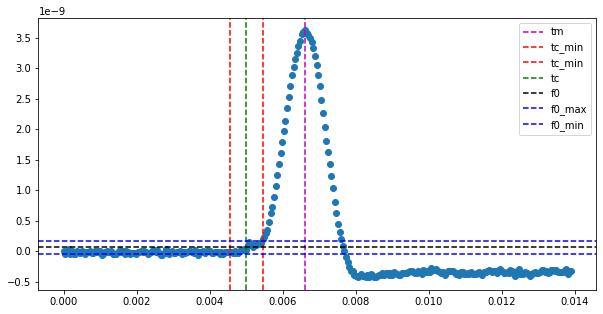

In [287]:
plt.plot(time_fit[idxDown], force_fit[idxDown], 'o')
plt.axvline(x=time_fit[idxDown][idx_tm], color='m', linestyle='--', label='tm')
plt.axvline(x=tc_min, color='r', linestyle='--', label='tc_min')
plt.axvline(x=tc_max, color='r', linestyle='--', label='tc_min')
plt.axvline(x=tc_fit, color='g', linestyle='--', label='tc')
plt.axhline(y=F0_init, color='k', linestyle='--', label='f0')
plt.axhline(y=F0_init+100e-12, color='b', linestyle='--', label='f0_max')
plt.axhline(y=F0_init-100e-12, color='b', linestyle='--', label='f0_min')
plt.legend()
plt.show()

In [312]:
from lmfit import Model, Parameters
ting_model_num = TingModel(indenter_shape, tip_parameter, 'numerical')
smooth_w = 1
t0 = 1
modelFt = 'analytical'
modelFt = 'numerical'
idx_tm = np.argmax(force_fit[idxDown])
model_for_fit = lambda time, E0, tc, betaE, F0: ting_model_num.model(time, E0, tc, betaE, F0, t0, force_fit[idxDown], ind_fit[idxDown], modelFt, vdrag, idx_tm, smooth_w, v0t, v0r)
model = Model(model_for_fit)
print(f'parameter names: {model.param_names}')
print(f'independent variables: {model.independent_vars}')
params = Parameters()
params.add('E0', value=hertz_E0*1000, min=hertz_E0/1e10, max=hertz_E0*1e5)
params.add('tc', value=tc_fit, min=tc_min, max=tc_max)
params.add('betaE', value=0.05, min=0.01, max=0.49)
params.add('F0', value=F0_init, min=F0_init-100e-12, max=F0_init+100e-12)

result = model.fit(force_fit[idxDown], params, time=time_fit[idxDown])

parameter names: ['E0', 'tc', 'betaE', 'F0']
independent variables: ['time']


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


In [313]:
print(result.fit_report)

<bound method ModelResult.fit_report of <lmfit.model.ModelResult object at 0x7f9fb27a7400>>


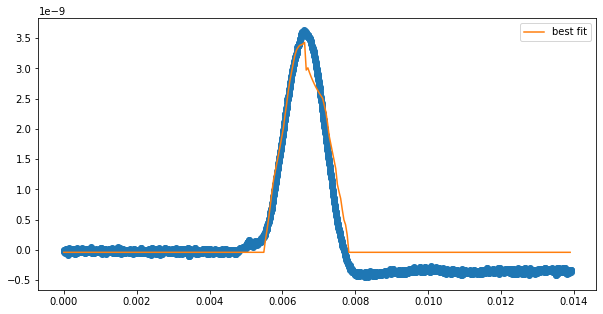

In [314]:
plt.plot(time_fit, force_fit, 'o')
# plt.plot(time_fit[idxDown], result.init_fit, '--', label='initial fit')
plt.plot(time_fit[idxDown], result.best_fit, '-', label='best fit')
plt.legend()
plt.show()

In [224]:
ting_model_num = TingModel(indenter_shape, tip_parameter, 'numerical')
ting_model_num.betaE_init = 0.05
ting_model_num.E0_init = hertz_E0/10000
ting_model_num.tc_init = tc_fit
ting_model_num.F0_init = F0_init
# ting_model_num.vdrag = 1.1e3/1e9
ting_model_num.fit(time_fit[idxDown], force_fit[idxDown], ind_fit[idxDown], t0=1, idx_tm=idx_tm, smooth_w=1)
ting_model_num.fit_report()
tc_num = ting_model_num.tc
f0_num = ting_model_num.F0


        # Fit parameters
        Indenter shape: paraboloid

        Tip paraneter: 3.0000000000000004e-08

        Model Format: numerical

        Viscous Drag: 0

        Smooth Window: 1

        t0: 1

        Maximum Indentation Time: 147

        Number of free parameters: 4

        E0: 3.0957945347277835

        tc: 0.0050050000000000025

        betaE: 0.05

        F0: 5.957633777470332e-11

        # Fit metrics
        MAE: -9.774119012217092e-11

        MSE: 8.90628216146834e-19

        RMSE: 9.437310083635242e-10

        Rsq: 8.210827148225075e-05

        Chisq: -5.499143590400319e-09

        RedChisq: -1.3747858976000797e-09

        


In [186]:
ting_model_analit = TingModel(indenter_shape, tip_parameter, 'analytical')
ting_model_analit.betaE_init = 0.05
ting_model_analit.E0_init = hertz_E0/10000
ting_model_analit.tc_init = tc_fit
#ting_model_analit.vdrag = 1.1e3/1e9
ting_model_analit.fit(time_fit[idxDown], force_fit[idxDown], ind_fit[idxDown], t0=1, idx_tm=idx_tm, smooth_w=1)
ting_model_analit.fit_report()
tc_analit = ting_model_analit.tc
f0_analit = ting_model_analit.F0


        # Fit parameters
        Indenter shape: paraboloid

        Tip paraneter: 3.0000000000000004e-08

        Model Format: analytical

        Viscous Drag: 0

        Smooth Window: 1

        t0: 1

        Maximum Indentation Time: 147

        Number of free parameters: 4

        E0: 3.0957945347277835

        tc: 0.0050050000000000025

        betaE: 0.05

        F0: 0.0

        # Fit metrics
        MAE: -1.573161827555051e-10

        MSE: 9.058432258805363e-19

        RMSE: 9.51757966018954e-10

        Rsq: 5.9446197697266e-05

        Chisq: 4.876106963671514e-08

        RedChisq: 1.2190267409178784e-08

        


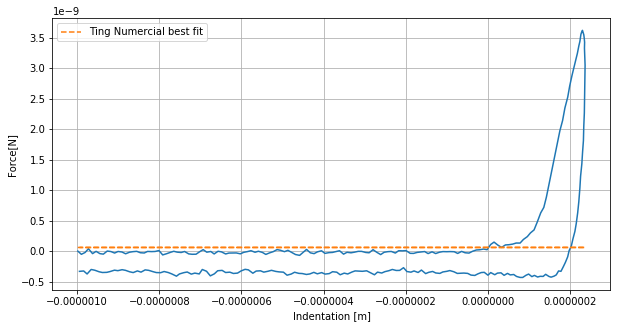

In [187]:
idx_tc = (np.abs(time_fit - tc_num)).argmin()
delta0 = ind_fit[idx_tc]
plt.plot(ind_fit[idxDown], force_fit[idxDown])
plt.plot(ind_fit[idxDown],
         ting_model_num.eval(time_fit[idxDown], force_fit[idxDown], ind_fit[idxDown], t0=t0, idx_tm=idx_tm, smooth_w=1), '--', label='Ting Numercial best fit')
plt.xlabel("Indentation [m]")
plt.ylabel("Force[N]")
plt.legend()
plt.grid()
plt.show()

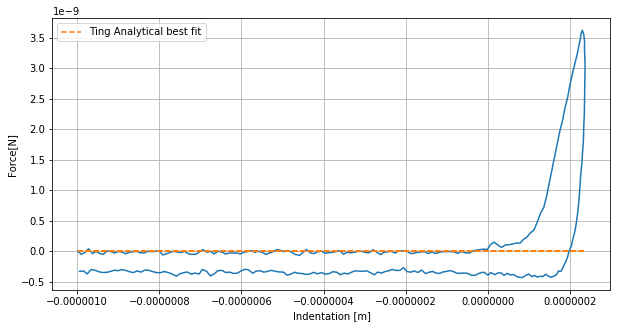

In [188]:
idx_tc = (np.abs(time_fit - tc_analit)).argmin()
delta0 = ind_fit[idx_tc]
plt.plot(ind_fit[idxDown], force_fit[idxDown])
plt.plot(ind_fit[idxDown], ting_model_analit.eval(time_fit[idxDown], force_fit[idxDown], ind_fit[idxDown], t0=t0, idx_tm=idx_tm, smooth_w=1), '--', label='Ting Analytical best fit')
plt.xlabel("Indentation [m]")
plt.ylabel("Force[N]")
plt.legend()
plt.grid()
plt.show()

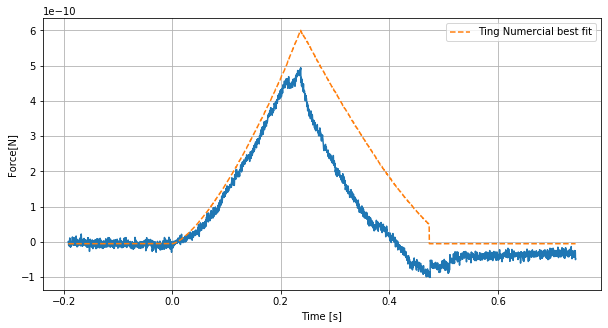

In [39]:
plt.plot(time_fit-tc_num, force_fit)
plt.plot(time_fit-tc_num, ting_model_num.eval(time_fit, force_fit, ind_fit, t0=t0, smooth_w=1), '--', label='Ting Numercial best fit')
plt.xlabel("Time [s]")
plt.ylabel("Force[N]")
plt.legend()
plt.grid()
plt.show()

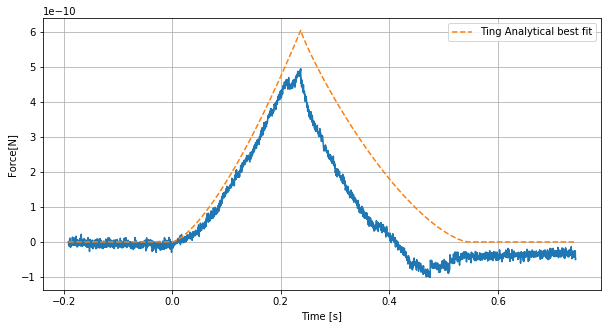

In [40]:
plt.plot(time_fit-tc_analit, force_fit+f0_analit)
plt.plot(time_fit-tc_analit, ting_model_analit.eval(time_fit, force_fit, ind_fit, t0=t0, smooth_w=1), '--', label='Ting Analytical best fit')
plt.xlabel("Time [s]")
plt.ylabel("Force[N]")
plt.legend()
plt.grid()
plt.show()